In [11]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'],
    "axes.labelsize": 22, 
    "axes.titlesize": 25, 
    "xtick.labelsize": 22, 
    "ytick.labelsize": 22, 
    "legend.fontsize": 20,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})

#### Define t($\omega$): 
$$t(\omega)=\frac{-\kappa}{(\Omega-\omega)-i\kappa-i\frac{g^2}{i(\Delta E-\omega)+\gamma}}$$

In [12]:
def S21 (w, k, kc, Omega, DeltaE, gamma, g):
    up = kc
    down = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = 1 - up / (1j * down)
    return np.abs(t)

 # NO noise

## Creamos base de datos

In [13]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    return k, DeltaE, gamma, g

num_datos = 10000

In [14]:
# #Creamos base de datos y guardamos en .txt
# k, kc, g, DeltaE = Parameters_generator (num_datos)
# np.savetxt('Parameters_previous-set.txt', np.column_stack((k, kc, g, DeltaE)),
#             header='\u03BA \u03BA_c g \u0394E', encoding='utf8') 

In [15]:
datos = np.loadtxt('Parameters_previous-set.txt', skiprows=1, usecols=(0, 1, 2))
k = datos[:,0]
kc = datos[:,1]
gamma = 6.5e-3
g = datos[:,2]
DeltaE = np.loadtxt('Parameters_previous-set.txt', skiprows=1, usecols=3)
Omega = 2.116451

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(2.09, 2.14, 2500)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))
t_values_noise = np.zeros((num_datos, len(w_values)))

for i in range (num_datos):
    t_values[i,:] = S21(w_values, k[i], kc[i], Omega, DeltaE[i], gamma, g[i])

# Añadir ruido basado en el valor mínimo de cada curva
min_values = np.min(t_values, axis=1)

# Inicializar los niveles de ruido
noise_levels = np.zeros((num_datos, len(w_values)))

# Ajustar los niveles de ruido
for i in range(num_datos):
    if min_values[i] > 0.975:
        noise_levels[i, :] = 0.15 * (1 - min_values[i])
    elif min_values[i] > 0.85:
        noise_levels[i, :] = 0.05 * (1 - min_values[i])
    else:
        noise_levels[i, :] = 0.015 * (1 - min_values[i])

# Crear el ruido y añadirlo a los valores originales
noise_matrix = np.random.normal(0, noise_levels)
t_values_noise = t_values + noise_matrix


## Red neuronal

### Tensorflow/Keras

In [16]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pickle

#### Preparamos datos e hiperparámetros

In [17]:
#Seleccionamos los datos de entrenamiento y de validación
indices = np.arange(num_datos)
indices_train, indices_post = train_test_split(indices, test_size=0.2)
indices_val, indices_test = train_test_split(indices_post, test_size=0.5)

x_train = t_values_noise[indices_train]
x_val = t_values_noise[indices_val]
x_test = t_values_noise[indices_test]
y_train = datos[indices_train]
y_val = datos[indices_val]
y_test = datos[indices_test]

# Normalizamos los datos
scaler_x = RobustScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)
x_test_norm = scaler_x.transform(x_test)

scaler_y = RobustScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

#Número de neuronas de entrada y salida
input_neurons  = x_train.shape[1]
output_neurons = y_train.shape[1]

# Comprobamos las dimensiones de nuestros datos
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)

#Elegimos los hiperparámetros
batch_size = 50
epochs = 100
optimizer = Adam()


8000 train samples
1000 validation samples
1000 test samples
x_train shape (8000, 2500)
y_train shape (8000, 3)


#### Definimos modelo

In [18]:
def Dense_five ():
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32 , activation='relu'))
    model.add(Dense(16 , activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


 #### Entrenamos

In [19]:
model =  Dense_five()

# Fiteamos el modelo
history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
                    epochs=epochs, verbose=2)

# Guardar el history en un archivo .pkl
with open('model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/100
160/160 - 2s - 14ms/step - loss: 0.2739 - mean_absolute_error: 0.4348 - val_loss: 0.2380 - val_mean_absolute_error: 0.4003
Epoch 2/100
160/160 - 1s - 4ms/step - loss: 0.2100 - mean_absolute_error: 0.3669 - val_loss: 0.1910 - val_mean_absolute_error: 0.3454
Epoch 3/100
160/160 - 1s - 4ms/step - loss: 0.1600 - mean_absolute_error: 0.3070 - val_loss: 0.1706 - val_mean_absolute_error: 0.3196
Epoch 4/100
160/160 - 1s - 4ms/step - loss: 0.1214 - mean_absolute_error: 0.2599 - val_loss: 0.1486 - val_mean_absolute_error: 0.2840
Epoch 5/100
160/160 - 1s - 4ms/step - loss: 0.0907 - mean_absolute_error: 0.2187 - val_loss: 0.1473 - val_mean_absolute_error: 0.2788
Epoch 6/100
160/160 - 1s - 4ms/step - loss: 0.0684 - mean_absolute_error: 0.1877 - val_loss: 0.1398 - val_mean_absolute_error: 0.2642
Epoch 7/100
160/160 - 1s - 4ms/step - loss: 0.0508 - mean_absolute_error: 0.1596 - val_loss: 0.1414 - val_mean_absolute_error: 0.2580
Epoch 8/100
160/160 - 1s - 4ms/step - loss: 0.0409 - mean_abs

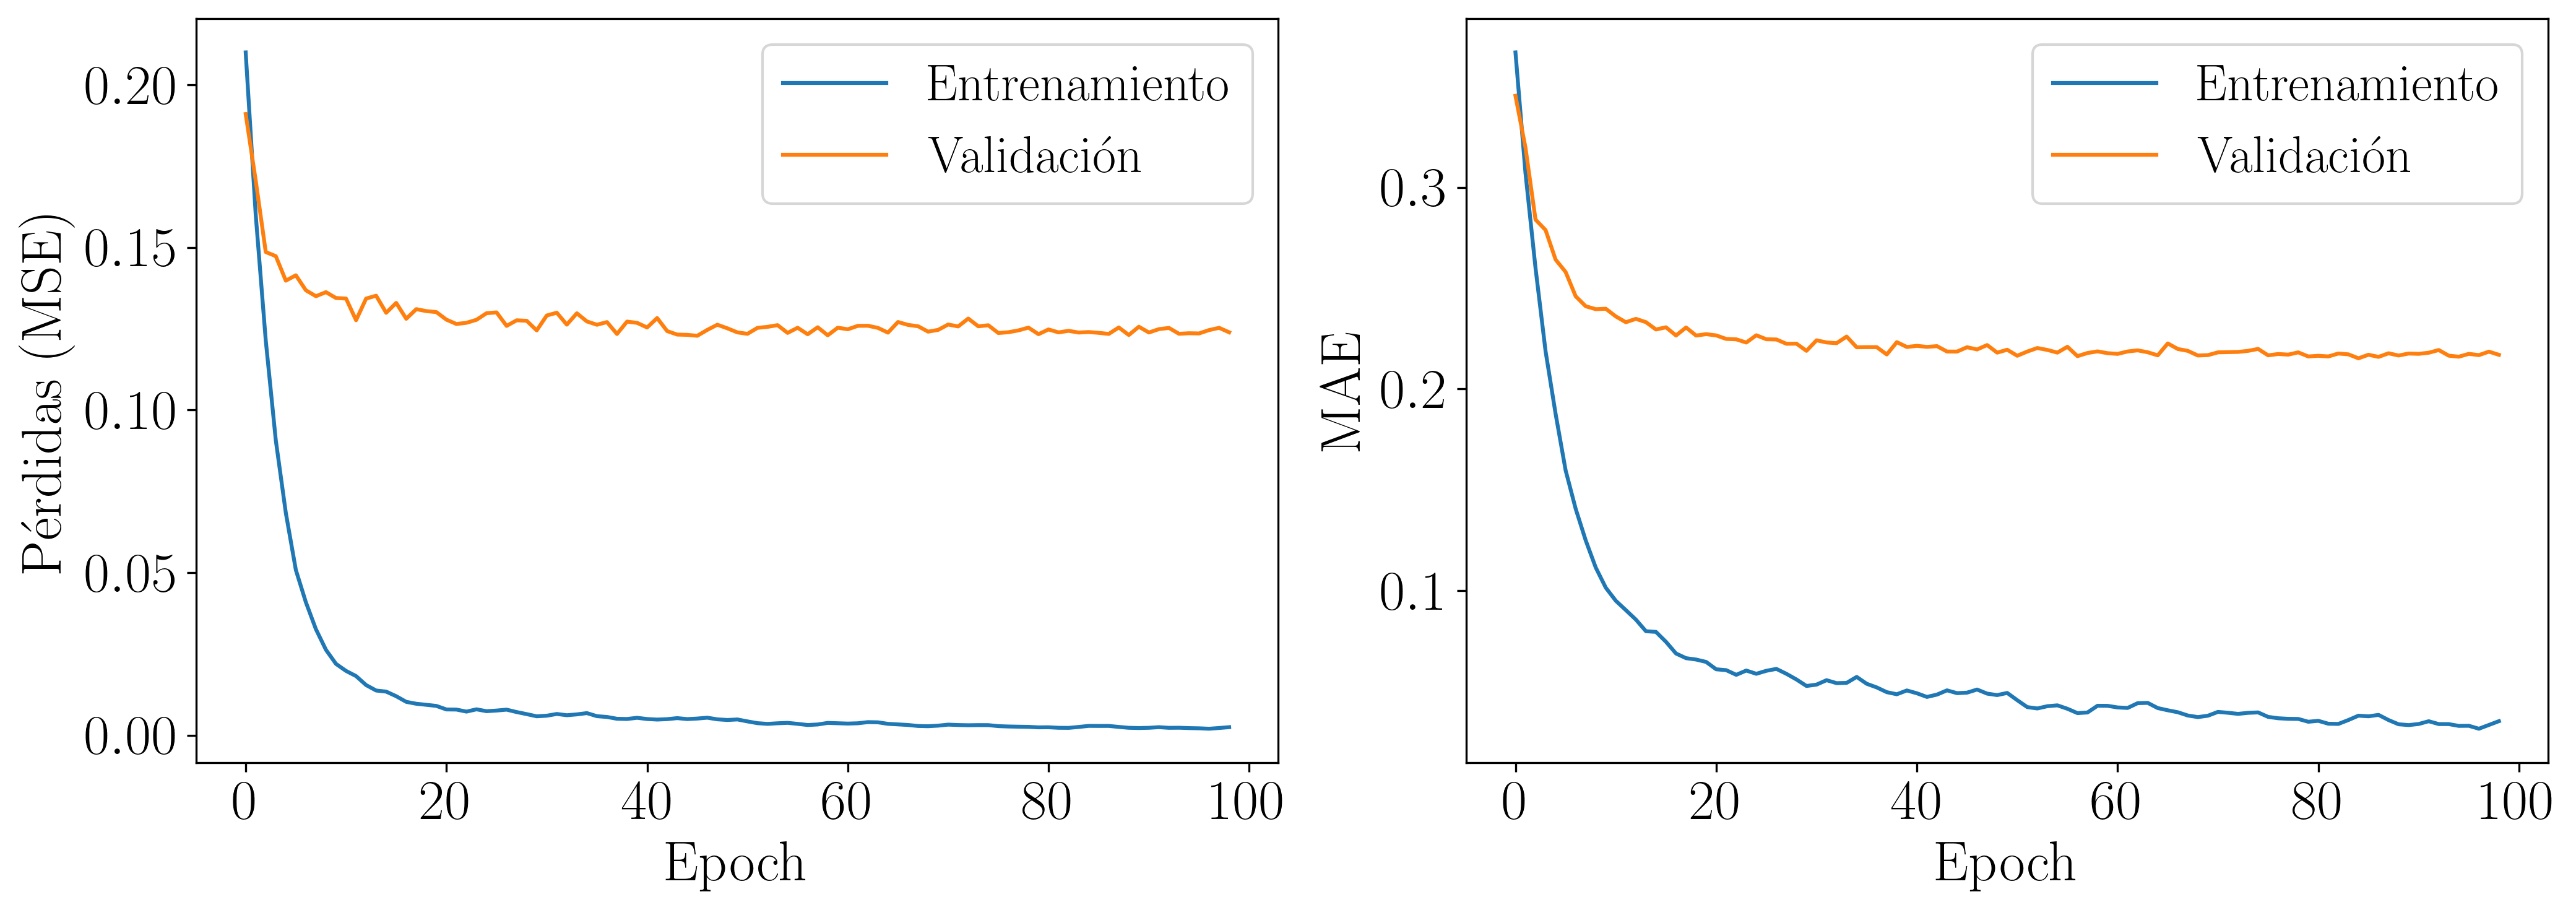

In [20]:
# Cargar el history desde el archivo .pkl
with open('model_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Crear una figura con dos subgráficos en una fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Primer subgráfico: Pérdida de entrenamiento y validación
ax1.plot(history['loss'][1:], label='Entrenamiento')
ax1.plot(history['val_loss'][1:], label='Validación')
ax1.set_ylabel('Pérdidas (MSE)')
ax1.set_xlabel('Epoch')
ax1.legend()

# Segundo subgráfico: MAE de entrenamiento y validación
ax2.plot(history['mean_absolute_error'][1:], label='Entrenamiento')
ax2.plot(history['val_mean_absolute_error'][1:], label='Validación')
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend()

# Mostrar la figura con los subgráficos
plt.tight_layout()
plt.show()